In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 600
import math
import datetime as dt
from tableone import TableOne, load_dataset
import itertools
import random
import seaborn as sns
import scipy.stats as stats

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/02.AUMCdb_SAKI_trajCluster/df_mixAK_fea3_C3_aumc.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt["groupHPD"].value_counts()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


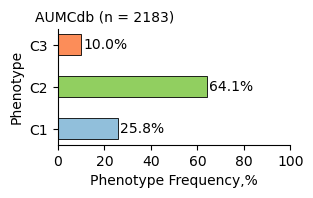

In [3]:
tmp = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
tmp.columns = ["groupHPD","count"]
tmp["count_all"] = len(all_lst)
tmp["Percentage"] = round(tmp["count"]/tmp["count_all"]*100,1)

plt.figure(figsize=(3,1.5))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.barh(tmp["groupHPD"].tolist(), tmp["Percentage"].tolist(),color=["#91cf60","#91bfdb","#fc8d59"],ec='black', ls='-', lw=0.6,height=0.5)
plt.xlabel("Phenotype Frequency,%")
plt.ylabel("Phenotype")
plt.yticks([1,2,3],[ 'C1', 'C2', 'C3'])
plt.xlim([0,100])
plt.title("AUMCdb (n = 2183)",fontsize=10,horizontalalignment="right")
plt.text(tmp[tmp["groupHPD"]==1]["Percentage"].tolist()[0]+1,1,str(tmp[tmp["groupHPD"]==1]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.text(tmp[tmp["groupHPD"]==2]["Percentage"].tolist()[0]+1,2,str(tmp[tmp["groupHPD"]==2]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.text(tmp[tmp["groupHPD"]==3]["Percentage"].tolist()[0]+1,3,str(tmp[tmp["groupHPD"]==3]["Percentage"].tolist()[0])+"%",verticalalignment="center")

plt.savefig("./result/AUMCdb_phenotype_frequency.pdf")
plt.show()


# Feature description - Three groups
- base info:

    age
    gender
    weight
    height
    los
    careunit
    
- AKI ：

    first kdigo stages
    max kdigo stages
    creatinine at baseline

- ICU events（septic shock：

    Mechanical ventilation
    Liquid resuscitation
    RRT
    kidney transplantation
    Vasopressor
    
- primary outcome：

    28-dmortality
    SAPS II score
    xx socre
    
- comorbidities：

    Hypertension 
    Congestive heart failure 
    Diabetes mellitus 
    Liver disease 
    Peripheral vascular disease
    ...

In [ ]:
# Basic characteristics
df_demo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/feature_data/df_aumc_basicinfo.csv")
df_demo = df_demo[['stay_id', "outtime",  'first_unittype', 'urgency','icu_stay_days', 'gender', 'age', 'weight', 'height', 'icu_expire_flag']] # hospital_expire_flag

# AKI stages
df_first_max_aki_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumc_first_and_max_stage.csv")
df_first_max_aki_stage = df_first_max_aki_stage[["stay_id","first_aki_onset","first_aki_stage","max_aki_stage","aki_endstage","aki_endstage_H7D"]]
df_demo = pd.merge(df_demo, df_first_max_aki_stage, how="left", on = "stay_id")
df_demo["icu_stay_days_after_SAAKI"] = (df_demo["outtime"] - df_demo["first_aki_onset"])/24

# AKI stages - uo crea
df_sk_first_and_max_stage_uc = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumc_sk_first_and_max_stage_uo_crea.csv")
df_sk_first_and_max_stage_uc = df_sk_first_and_max_stage_uc[["stay_id","max_aki_stage_uo", "max_aki_stage_crea" ]]
df_demo = pd.merge(df_demo, df_sk_first_and_max_stage_uc, how="left", on = "stay_id")

 
# AKI course
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumc_first_and_max_stage.csv")
df_time["AKI_course"] = (df_time["aki_endtime_H7D"] - df_time["first_aki_onset"])/24
df_time = df_time[["stay_id","AKI_course"]]
df_demo = pd.merge(df_demo, df_time, how="left", on = "stay_id")

# lifesupport
df_lifesupport = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/treatment/aumcdb_lifesupport.csv")
df_demo = pd.merge(df_demo, df_lifesupport, how="left", on = "stay_id")

# mortality
df_mortality = pd.read_csv("./sk_survival.csv")
df_mortality = df_mortality[['stay_id', 'mortality_28d',  'groupHPD']]
df_demo = pd.merge(df_demo, df_mortality, how="left", on = "stay_id")

#Baseline creatinine
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3//00.data_aumc/disease_definition/AKI/baseline_creatinine.csv")
df_base_crea = df_base_crea.rename(columns={"admissionid":"stay_id"})
df_base_crea["baseline_creatinine"] *= 0.01131
df_base_crea.columns = ["stay_id","baseline_Scr"]
df_demo = pd.merge(df_demo, df_base_crea, how="left", on = "stay_id")

# Add peak and discharge creatinine
df_peak_discharge = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc//disease_definition/AKI/df_peak_discharge.csv")
df_demo = pd.merge(df_demo, df_peak_discharge, how="left", on="stay_id")

# Add the diagnostic criteria for AKI
df_criteria = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/AKI_diagnose_criteria.csv")
df_demo = pd.merge(df_demo, df_criteria, how="left", on="stay_id")
df_demo= df_demo[df_demo.stay_id.isin(all_lst)]

#Add the SA-AKI type
df_event = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc//disease_definition/AKI/aumcdb_sk_event_time.csv")
df_event = df_event[df_event.stay_id.isin(all_lst)]
df_event["los_sepsis_saaki"] = (df_event["saki_onset"] - df_event["sepsis_onset"])/1
df_event.loc[df_event["los_sepsis_saaki"]<=48,"SA-AKI_type"] = "Early SA-AKI"
df_event.loc[df_event["los_sepsis_saaki"]>48,"SA-AKI_type"] = "Late SA-AKI"
df_event = df_event[['stay_id', 'los_sepsis_saaki','SA-AKI_type']]
df_demo = pd.merge(df_event, df_demo, how="inner", on = "stay_id")

# How long after sepsi does aki occur
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumcdb_sk_event_time.csv")
df_time = df_time[df_time.stay_id.isin(all_lst)]
df_time["los_saki_minus_sepsis"] = (df_time["aki_onset"] - df_time["sepsis_onset"])/1
df_time["los_aki_minus_intime"] = (df_time["aki_onset"] - df_time["intime"])/1
df_time["los_sepsis_minus_intime"] = (df_time["sepsis_onset"] - df_time["intime"])/1
df_demo = pd.merge(df_demo, df_time, how="left", on = "stay_id")

# Comorbidity
# df_icd = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/diag_icd/df_mimic_diag_icd.csv")
# df_demo_base_add = pd.merge(df_demo_base_add, df_icd, how="left",on="stay_id")
# df_demo_base_add[[ ]] = df_demo_base_add[[ ]].fillna(0)
# df_demo_base_add[df_icd.columns.tolist()] = df_demo_base_add[df_icd.columns.tolist()].astype("int")

# Draw a table
columns = ['first_unittype', 'urgency',
        'icu_stay_days',"icu_stay_days_after_SAAKI", "AKI_course", 'gender', 'age', 'weight', 'height','icu_expire_flag', 'SA-AKI_type',# 'hospital_expire_flag',
        'baseline_Scr','Peak_Scr','Discharge_Scr', 'first_aki_stage', 'max_aki_stage',"max_aki_stage_uo", "max_aki_stage_crea","aki_endstage","aki_endstage_H7D", "AKI_criteria",
       'is_vaso', 'is_mv', 'is_rrt','los_sepsis_minus_intime','los_aki_minus_intime','los_saki_minus_sepsis'
       ]
categorical = ['first_unittype', 'urgency'
               , 'gender', 'icu_expire_flag','SA-AKI_type', # 'hospital_expire_flag',
         'first_aki_stage', 'max_aki_stage',"max_aki_stage_uo", "max_aki_stage_crea","aki_endstage","aki_endstage_H7D", "AKI_criteria",
       'is_vaso', 'is_mv', 'is_rrt'
              ]
nonnormal = ["baseline_Scr",'Peak_Scr','Discharge_Scr','icu_stay_days',"icu_stay_days_after_SAAKI",'los_sepsis_minus_intime','los_aki_minus_intime','los_saki_minus_sepsis',"AKI_course",'age', 'weight', 'height']
df_demo_stat = TableOne(df_demo, columns=columns, nonnormal=nonnormal, categorical=categorical, groupby = ["groupHPD"], pval=True)
df_demo_stat = pd.DataFrame(df_demo_stat.tableone).reset_index()
df_demo_stat = df_demo_stat.droplevel(level=0, axis=1)
df_demo_stat = df_demo_stat.loc[:,['','Overall', '1.0', '2.0', '3.0', 'P-Value']]
df_demo_stat.columns = ['feature', 'type','Overall',  'C1', 'C2', 'C3', 'P-Value']
df_demo_stat.to_csv("./result/AUMCdb_clusters_characteristics.csv",index=False)
df_demo_stat

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tableone/tableone.py:921: FutureWarning: The provided callable <function mean at 0x2b9273fec1f0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_cont = pd.pivot_table(cont_data,
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tableone/tableone.py:921: FutureWarning: The provided callable <function median at 0x2b92be214040> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_cont = pd.pivot_table(cont_data,
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tableone/tableone.py:921: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable w

,feature,type,Overall,C1,C2,C3,P-Value
0,n,,2183,522,1244,212,
1,"first_unittype, n (%)",IC,1791 (82.0),419 (80.3),1005 (80.8),194 (91.5),0.002
2,"first_unittype, n (%)",IC&MC,290 (13.3),75 (14.4),184 (14.8),11 (5.2),
3,"first_unittype, n (%)",MC,102 (4.7),28 (5.4),55 (4.4),7 (3.3),
4,"urgency, n (%)",0,967 (44.3),245 (46.9),532 (42.8),86 (40.6),0.173
5,"urgency, n (%)",1,1216 (55.7),277 (53.1),712 (57.2),126 (59.4),
6,"icu_stay_days, median [Q1,Q3]",,"7.9 [3.4,16.6]","10.2 [4.9,20.2]","7.8 [3.5,15.4]","4.2 [2.6,14.1]",<0.001
7,"icu_stay_days_after_SAAKI, median [Q1,Q3]",,"7.5 [3.0,16.1]","10.1 [4.4,19.7]","7.4 [2.9,15.0]","3.6 [2.2,13.8]",<0.001
8,"AKI_course, median [Q1,Q3]",,"2.4 [1.2,4.6]","4.6 [2.0,10.7]","1.9 [1.0,3.2]","3.2 [1.9,11.9]",<0.001
9,"gender, n (%)",F,740 (34.7),197 (38.6),398 (32.6),70 (34.0),0.058


# Prognosis

## 28d mortality

In [5]:
def add_aumc_survival(df_time,time):
    df_admit = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3//00.data_aumc/feature_data/df_aumc_basicinfo.csv")
    df_admit = df_admit[["stay_id","deathtime","outtime","expire_flag"]]
    df_admit = pd.merge(df_admit,df_time, how="inner",on="stay_id" )
    # 添加死亡flag
    df_admit["survival_day"] = ((df_admit["deathtime"] - df_admit[time])//24)
    df_admit["survival_day_"] = ((df_admit["outtime"] - df_admit[time])//24)
    df_admit = df_admit.loc[:,['stay_id', 'survival_day', "survival_day_", "expire_flag"]]
    df_admit["survival_day"] = round(df_admit["survival_day"],0)
    df_admit["survival_day_"] = round(df_admit["survival_day_"],0)
    # 28 day mortality
    df_admit["mortality_28d"] = df_admit["expire_flag"]
    df_admit["survival_28day"] = df_admit["survival_day"]
    df_admit.loc[(df_admit["survival_day"]>=30), "mortality_28d"] = 0
    
    df_admit["mortality_7d"] = df_admit["expire_flag"]
    df_admit["survival_7day"] = df_admit["survival_day"] 
    df_admit.loc[(df_admit["survival_day"]>=7), "mortality_7d"] = 0

    df_admit["survival_day"].fillna(df_admit["survival_day_"], inplace=True)
    df_admit["survival_7day"].fillna(df_admit["survival_day_"], inplace=True)
    df_admit["survival_28day"].fillna(df_admit["survival_day_"], inplace=True)

    df_admit.loc[df_admit["survival_28day"]>30, "survival_28day"] = 30
    df_admit.loc[df_admit["survival_7day"]>7, "survival_7day"] = 7
    return df_admit

## saki
df_saki_time =  pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumcdb_sk_event_time.csv")
df_saki_time  = df_saki_time[["stay_id", "saki_onset"]]
df_saki_time = df_saki_time.dropna(how='all', subset=['saki_onset'])
tmp_df = add_aumc_survival(df_saki_time,"saki_onset")
df_admit = pd.merge(tmp_df, df_type_filt,how="inner",on="stay_id")
df_admit.to_csv("sk_survival.csv", index=False)
df_admit.head(1)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-fcf68b2fd1f1>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_admit["survival_day"].fillna(df_admit["survival_day_"], inplace=True)

,stay_id,survival_day,survival_day_,expire_flag,mortality_28d,survival_28day,mortality_7d,survival_7day,groupHPD
0,5,2.0,2.0,0,0,2.0,0,2.0,2


In [ ]:
# see R

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Vertical change

In [7]:
fea_min_dict = {'heart_rate':60, 'sbp':90, 'dbp':60, 'mbp':70,'resp_rate':12, 'temperature':35.8,'glucose':72,
                'bicarbonate':22, 'ph':7.35, 'baseexcess':-2,'totalco2':22, 'lactate':0.5,  'pco2':35, 'aniongap':3,
                'spo2':95, 'fio2':21, 'aado2':5, 'pao2fio2ratio':300,'po2':75, 'so2':94,
                'alt':7, 'alp':40, 'ast':8, 'bilirubin_total':0.1,  'albumin':3.5,
                'chloride':100, 'potassium':3.7,'calcium':8.5, 'sodium':136,
            'inr':0.8, 'pt':11, 'ptt':25, 
                'sofa':0, 'respiration_sofa':0,'coagulation_sofa':0, 'liver_sofa':0, 'cardiovascular_sofa':0, 'cns_sofa':0,
                 'mch':27.5, 'mchc':32, 'mcv':80, 'platelet':150, 'rbc':4.2, 'rdw':12, 'hematocrit':36, 'hemoglobin':12, 'wbc':5
           }
fea_max_dict = {'heart_rate':100, 'sbp':120, 'dbp':80, 'mbp':105,'resp_rate':20, 'temperature':36.9,'glucose':180,
                 'bicarbonate':29, 'ph':7.45, 'baseexcess':2,'totalco2':28, 'lactate':1.6,  'pco2':45, 'aniongap':11,
                'spo2':100, 'fio2':100, 'aado2':15, 'pao2fio2ratio':500,'po2':100, 'so2':98,
                'alt':55, 'alp':129, 'ast':48, 'bilirubin_total':1.2,  'albumin':5,
                'chloride':107, 'potassium':5.1,'calcium':10.2, 'sodium':144,
            'inr':1.5, 'pt':17, 'ptt':33, 
             'sofa':2, 'respiration_sofa':2,'coagulation_sofa':2, 'liver_sofa':2, 'cardiovascular_sofa':2, 'cns_sofa':2,
                 'mch':33.2, 'mchc':36, 'mcv':100, 'platelet':450, 'rbc':6.1, 'rdw':15, 'hematocrit':55, 'hemoglobin':17.5, 'wbc':10
           }

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Feature change

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-8-534eb420184a>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
<ipython-input-8-534eb420184a>:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
<ipython-input-8-534eb420

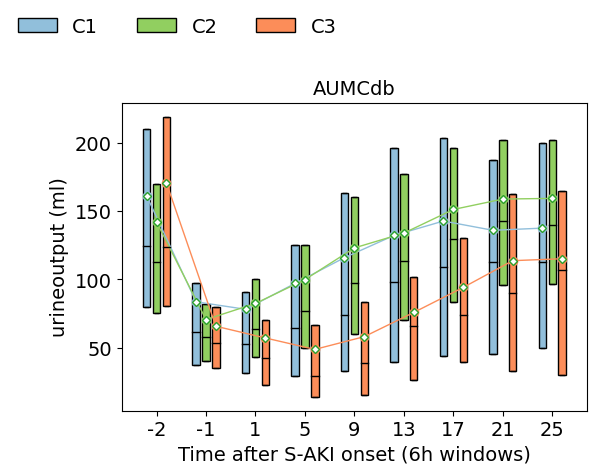

<ipython-input-8-534eb420184a>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
<ipython-input-8-534eb420184a>:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
<ipython-input-8-534eb420184a>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#fc8d59")


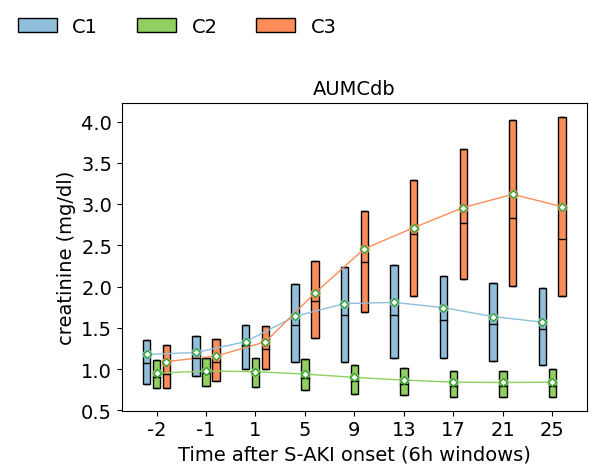

<ipython-input-8-534eb420184a>:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
<ipython-input-8-534eb420184a>:48: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
<ipython-input-8-534eb420184a>:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#fc8d59")


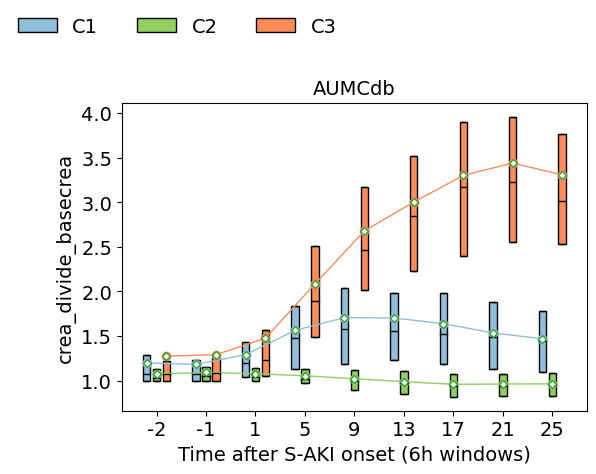

In [ ]:
import matplotlib.pyplot as plt
fea_lst = [ "urineoutput", "creatinine","crea_divide_basecrea"] #""renal_sofa",
lab_dict = {"urineoutput": "urineoutput (ml)",  "creatinine": "creatinine (mg/dl)", "crea_divide_basecrea":"crea_divide_basecrea"}

#fea_lst = [
#'heart_rate', 'sbp', 'dbp', 'mbp','resp_rate', 'temperature','glucose'#,
#'gcs', 'gcs_motor','gcs_verbal', 'gcs_eyes', 'gcs_unable'#,  
# 'bicarbonate', 'ph', 'baseexcess','totalco2', 'lactate',  'pco2', 'aniongap'#,
# 'spo2', 'fio2', 'aado2', 'pao2fio2ratio','po2', 'so2'#, 
#'inr', 'pt', 'ptt', 
# 'alt', 'alp', 'ast', 'bilirubin_total',  'albumin',
#'sofa', 'respiration_sofa','coagulation_sofa', 'liver_sofa', 'cardiovascular_sofa', 'cns_sofa',
# 'chloride', 'potassium','calcium', 'sodium', # 'free_calcium', 
# 'basophils_abs', 'eosinophils_abs', 'lymphocytes_abs', 'monocytes_abs','neutrophils_abs', 'basophils', 'eosinophils', 'lymphocytes','monocytes', 'neutrophils',
# 'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw', 'hematocrit', 'hemoglobin', 'wbc'
#]
give_bound = False
for fea in fea_lst:
    df_fea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/02.AUMCdb_SAKI_trajCluster/sk_feature_timescale_Fb2_aumc.csv")
    choose_time_lst = [-2,-1,1,5,9,13,17,21,25] # [-2,-1,1,3,5,7,9,11,13,15,17,19,21,23,25,27] 
    df_fea =  df_fea[df_fea["time"].isin(choose_time_lst)] 
    df = pd.merge(df_type_filt,df_fea, how="inner",on="stay_id")
    df1 = df[df["groupHPD"]==1][[fea,"time"]]
    df2 = df[df["groupHPD"]==2][[fea,"time"]]
    df3 = df[df["groupHPD"]==3][[fea,"time"]]
    dataframes1 = [group[1] for group in df1.groupby('time')]
    dataframes2 = [group[1] for group in df2.groupby('time')]
    dataframes3 = [group[1] for group in df3.groupby('time')]

    fig = plt.figure(figsize=(6,4))
    choose_time_lst_x = range(-1,len(choose_time_lst)-1)
    choose_time_lst1 = [i-0.2 for i in choose_time_lst_x]
    choose_time_lst2 = choose_time_lst_x
    choose_time_lst3 = [i+0.2 for i in choose_time_lst_x]
    medianprops = dict(linestyle='-', linewidth=1, color='black') #中位线设置
    meanprops = dict(color='b', markersize=4,marker="D",markerfacecolor="white")

    boxprops1 = dict(color='black',facecolor='#91bfdb',edgecolor="black")
    boxprops2 = dict(color='black',facecolor='#91cf60',edgecolor="black")
    boxprops3 = dict(color='black',facecolor='#fc8d59',edgecolor="black")
    pa = plt.boxplot([df[fea] for df in dataframes1],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops1, positions=choose_time_lst1,patch_artist=True,meanprops=meanprops, medianprops=medianprops )
    pb = plt.boxplot([df[fea] for df in dataframes2],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops2,positions=choose_time_lst2,patch_artist=True,meanprops=meanprops, medianprops=medianprops )
    pc = plt.boxplot([df[fea] for df in dataframes3],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops3,positions=choose_time_lst3,patch_artist=True,meanprops=meanprops, medianprops=medianprops )
    # Line graph with added average values
    mean_points = [pa['means'][i].get_xydata()[0] for i in range(len(pa['means']))]
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91bfdb")
    mean_points = [pb['means'][i].get_xydata()[0] for i in range(len(pb['means']))]
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#91cf60")
    mean_points = [pc['means'][i].get_xydata()[0] for i in range(len(pc['means']))]
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color="#fc8d59")
    if give_bound == True:
        min_V = fea_min_dict[fea]
        max_V = fea_max_dict[fea]
        plt.hlines(y=[min_V,max_V], xmin=-1, xmax=6, color='#bdbdbd',linestyles="dashed")
        
    label_lst = ["C1", "C2", "C3"]
    plt.legend([pa["boxes"][0], pb["boxes"][0], pc["boxes"][0]], ["C1", "C2", "C3"], loc= 'lower right',bbox_to_anchor=(0.5,1.16),ncol=3,frameon=False,fontsize=14)

    x_position= choose_time_lst_x
    x_position_fmt=choose_time_lst
    plt.xticks(x_position, x_position_fmt,fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("AUMCdb",fontsize=14)
    plt.xlabel('Time after S-AKI onset (6h windows)',fontsize=14)
    plt.ylabel(lab_dict[fea],fontsize=14)
    tit = "./result/AUMCdb_" + fea + ".pdf"
    plt.savefig(tit)
    plt.show()

# Changes of AKI stages at each moment + survival status - 6h

## The changes in AKIstage and death at every moment - 6 hours

In [9]:
df_sur = pd.read_csv("./sk_survival.csv")
df_sur["survival_168H"] = df_sur["survival_28day"] * 4
df_sur = df_sur.loc[:,["stay_id", "groupHPD", "survival_168H","mortality_28d"]]  # survival_168H即院内生存时间

com_lst = []
for i in df_sur.stay_id.unique().tolist():
    for j in range(-2,29,1):
        com_lst.append([i,j])
df_com = pd.DataFrame(com_lst,columns=["stay_id", "time"])            

df_sur_ = pd.merge(df_com, df_sur, how="inner", on="stay_id")
df_sur_["survival_state"] = 0
df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==0),"survival_state"]  = "A"
df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==1),"survival_state"]  = "D"
df_sur_ = df_sur_.loc[:,["stay_id","time","survival_state"]]
df_sur_.head(2)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-b1de25902839>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==0),"survival_state"]  = "A"


,stay_id,time,survival_state
0,5,-2,0
1,5,-1,0


## Changes of AKI stages at every moment - 6h

In [10]:
select_time_lst =  [0,1,5,9,13,17,21,25] #[0,1,2,3,4,5,7,9,11,13,15,20,24,26,27,28]
import math
map_dict ={}
map_dict[0] = "Onset"
for i in range(1,29,1):
    j = "D" + str(math.ceil(i/4)) + "_" + str(i%4)
    map_dict[i] = j.replace("_0","_4")
    
xticks = [ map_dict[i] for i in select_time_lst]
print(xticks)

['Onset', 'D1_1', 'D2_1', 'D3_1', 'D4_1', 'D5_1', 'D6_1', 'D7_1']


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Complete 28 stages
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_aumc/disease_definition/AKI/aumc_kdigo_stages_based_time.csv")

# Fill in the points without AKI stages records with survival and death
tmp_df = pd.merge(df_stage, df_sur_, how="right", on= ["stay_id","time"])
tmp_df["aki_stage"].fillna(tmp_df["survival_state"],inplace=True)
tmp_df.loc[tmp_df["aki_stage"]=="A","aki_stage"] = 5
tmp_df.loc[tmp_df["aki_stage"]=="D","aki_stage"] = 4

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-fa279f6999e2>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp_df["aki_stage"].fillna(tmp_df["survival_state"],inplace=True)
<ipyth

In [ ]:
# The number of patients for each category and each class at each time point
df_aki_all = tmp_df
df_aki_all = pd.merge(df_aki_all,df_type_filt, how="inner",on="stay_id")
df_aki_all = df_aki_all.loc[:,['stay_id', 'time', 'aki_stage', 'groupHPD']]
df_aki_all = df_aki_all.groupby(["time","groupHPD","aki_stage"]).agg("count").reset_index()

# Build a complete dataframe # time -2-29
# aki_stage 0-3
# groupHPD 1-3
com_lst = []
for i in range(-2,29,1): # time
    for j in range(0,6,1): # aki_stage
        for k in range(1,4,1): # groupHPD
            com_lst.append([i,j,k])
df_com = pd.DataFrame(com_lst,columns=["time", "aki_stage", "groupHPD"])            
df_aki_all = pd.merge(df_com, df_aki_all, how="left", on=["time","aki_stage", "groupHPD"])
df_aki_all = df_aki_all.fillna(0)

df_stayid_sum = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_stayid_sum.columns = [ 'groupHPD', 'stay_id_sum']

df_aki_all_ = pd.merge(df_aki_all, df_stayid_sum, how="inner", on=["groupHPD"])
df_aki_all_["percent"] = round(df_aki_all_["stay_id"]/df_aki_all_["stay_id_sum"]*100,2)
df_aki_all_ = df_aki_all_[df_aki_all_["time"].isin(select_time_lst)]
df1 = df_aki_all_[df_aki_all_["groupHPD"] ==1]
df2 = df_aki_all_[df_aki_all_["groupHPD"] ==2]
df3 = df_aki_all_[df_aki_all_["groupHPD"] ==3]

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


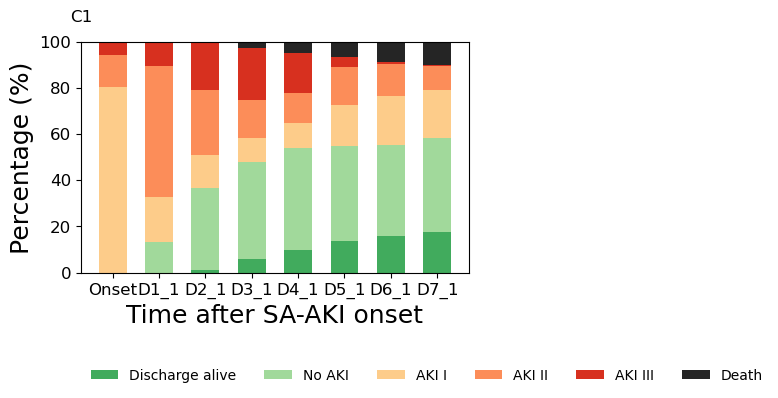

In [13]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df1 
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False)
plt.title('C1',x=0,y=1.05)#AUMCdb -
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/AUMCdb_C1_AKIstages.pdf', bbox_inches = 'tight')
plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


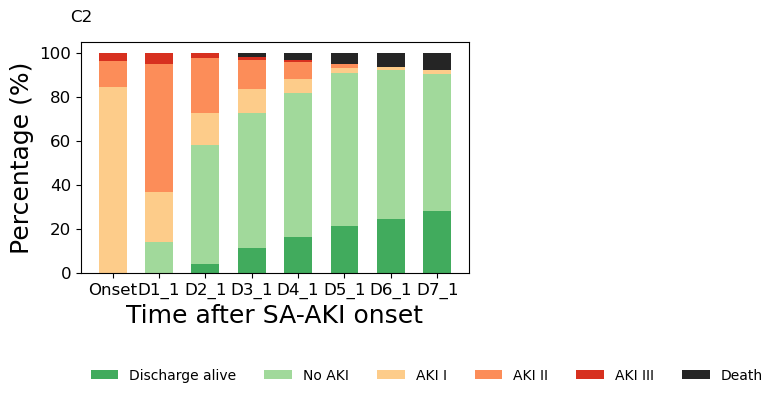

In [14]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df2
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False)
plt.title('C2',x=0,y=1.05) #AUMCdb - 
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/AUMCdb_C2_AKIstages.pdf', bbox_inches = 'tight')
plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


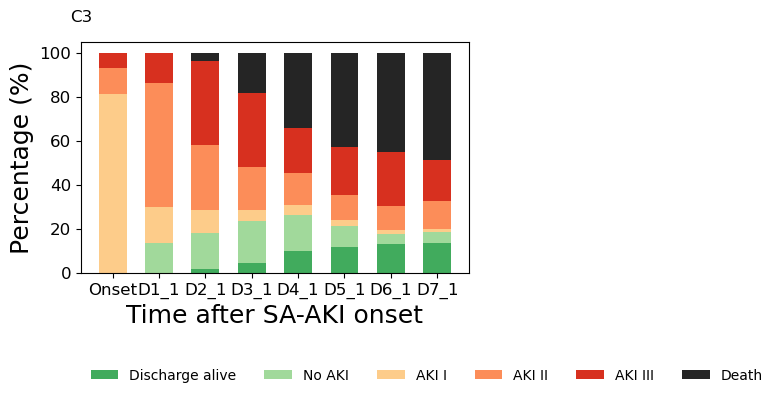

In [15]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df3
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False)
plt.title('C3',x=0,y=1.05) #AUMCdb - 
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/AUMCdb_C3_AKIstages.pdf', bbox_inches = 'tight')
plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


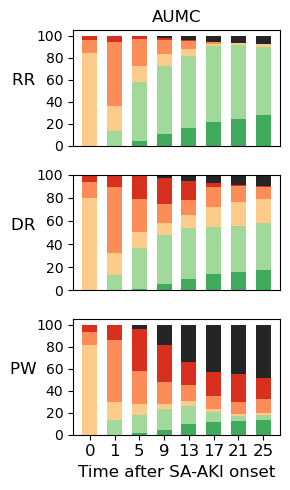

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(3, 5), sharex=True)

for i, df in enumerate([ df2,df1, df3]):
    ind = df_aki_all_.time.unique().tolist()
    ind = sorted(range(len(ind)))

    AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
    AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
    AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
    AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
    Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
    alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

    width = 0.6
    p0 = axs[i].bar(ind, alive, width=width, color='#41ab5d')
    p1 = axs[i].bar(ind, AKI0, bottom=alive, width=width, color='#a1d99b')
    p2 = axs[i].bar(ind, AKI1, width=width, bottom=alive + AKI0, color='#fdcc8a')
    p3 = axs[i].bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1, color='#fc8d59')
    p4 = axs[i].bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2, color='#d7301f')
    p5 = axs[i].bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3, color='#252525')

    axs[0].set_ylabel("RR   ", fontsize=12,rotation=0)
    axs[1].set_ylabel("DR   ", fontsize=12,rotation=0)
    axs[2].set_ylabel("PW   ", fontsize=12,rotation=0)
    axs[i].set_yticks(np.arange(0, 110, 20), fontsize=12)
    axs[0].set_title("AUMC")
    axs[i].set_xticks([])
    axs[0].tick_params(axis='x', which='both', bottom=False)
    axs[1].tick_params(axis='x', which='both', bottom=False)
        
plt.xlabel("Time after SA-AKI onset", fontsize=12)
#plt.ylabel("Percentage (%)")
plt.xticks(ind, select_time_lst, fontsize=12)
# plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]),
#                   ('Discharge alive', 'No AKI', 'AKI I', 'AKI II', 'AKI III', 'Death'),
#                   bbox_to_anchor=(0.01, 3.5), loc=3, borderaxespad=0, ncol=6, frameon=False)
plt.subplots_adjust(hspace=0.01)
plt.tight_layout()

plt.savefig('./result/AUMC_Combined_AKIstages.png', bbox_inches='tight', dpi=300)
plt.savefig('./result/AUMC_Combined_AKIstages.pdf', bbox_inches='tight', dpi=300)
plt.show()
